In [2]:
import numpy as np
import pandas as pd

import joblib
import sys

from importlib import reload


from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import MinMaxScaler

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from funciones import multiple_plot
import warnings
warnings.filterwarnings('ignore')

### Cargue del Dataset

In [3]:
d=pd.read_csv('3_Fuel_Consumption_2000-2022_Prep.csv')

In [4]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14093 entries, 0 to 14092
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   YEAR              14093 non-null  int64  
 1   RANGE_CATEGORY    14093 non-null  object 
 2   VEHICLE CLASS     14093 non-null  object 
 3   ENGINE SIZE       14093 non-null  float64
 4   CYLINDERS         14093 non-null  int64  
 5   FUEL              14093 non-null  object 
 6   FUEL CONSUMPTION  14093 non-null  float64
 7   KMXGALON          14093 non-null  float64
 8   EMISSIONS         14093 non-null  int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 991.0+ KB


### Datos de entrada

#### Variables categóricas

In [5]:
catCols = d.select_dtypes(include = ["object", 'category']).columns.tolist()
d[catCols].head()

RANGE_CATEGORY     VEHICLE CLASS FUEL
0      MID_RANGE         TRUCK_VAN    O
1      MID_RANGE         TRUCK_VAN    X
2      MID_RANGE     SEDAN_COMPACT    X
3      MID_RANGE  MIDSIZE_FULLSIZE    Z
4      MID_RANGE         TRUCK_VAN    X

#### Variables númericas

In [6]:
numCols=d.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()
d[numCols].head()

YEAR  ENGINE SIZE  CYLINDERS  FUEL CONSUMPTION  KMXGALON  EMISSIONS
0  2007          5.3          8              21.0  24.14010        298
1  2020          5.3          8              15.9  32.18680        326
2  2001          2.0          4               9.6  53.10822        198
3  2018          2.3          4              12.2  41.84284        252
4  2005          5.6          8              17.4  30.57746        345

#### Visualización de variables numéricas con respecto al precio


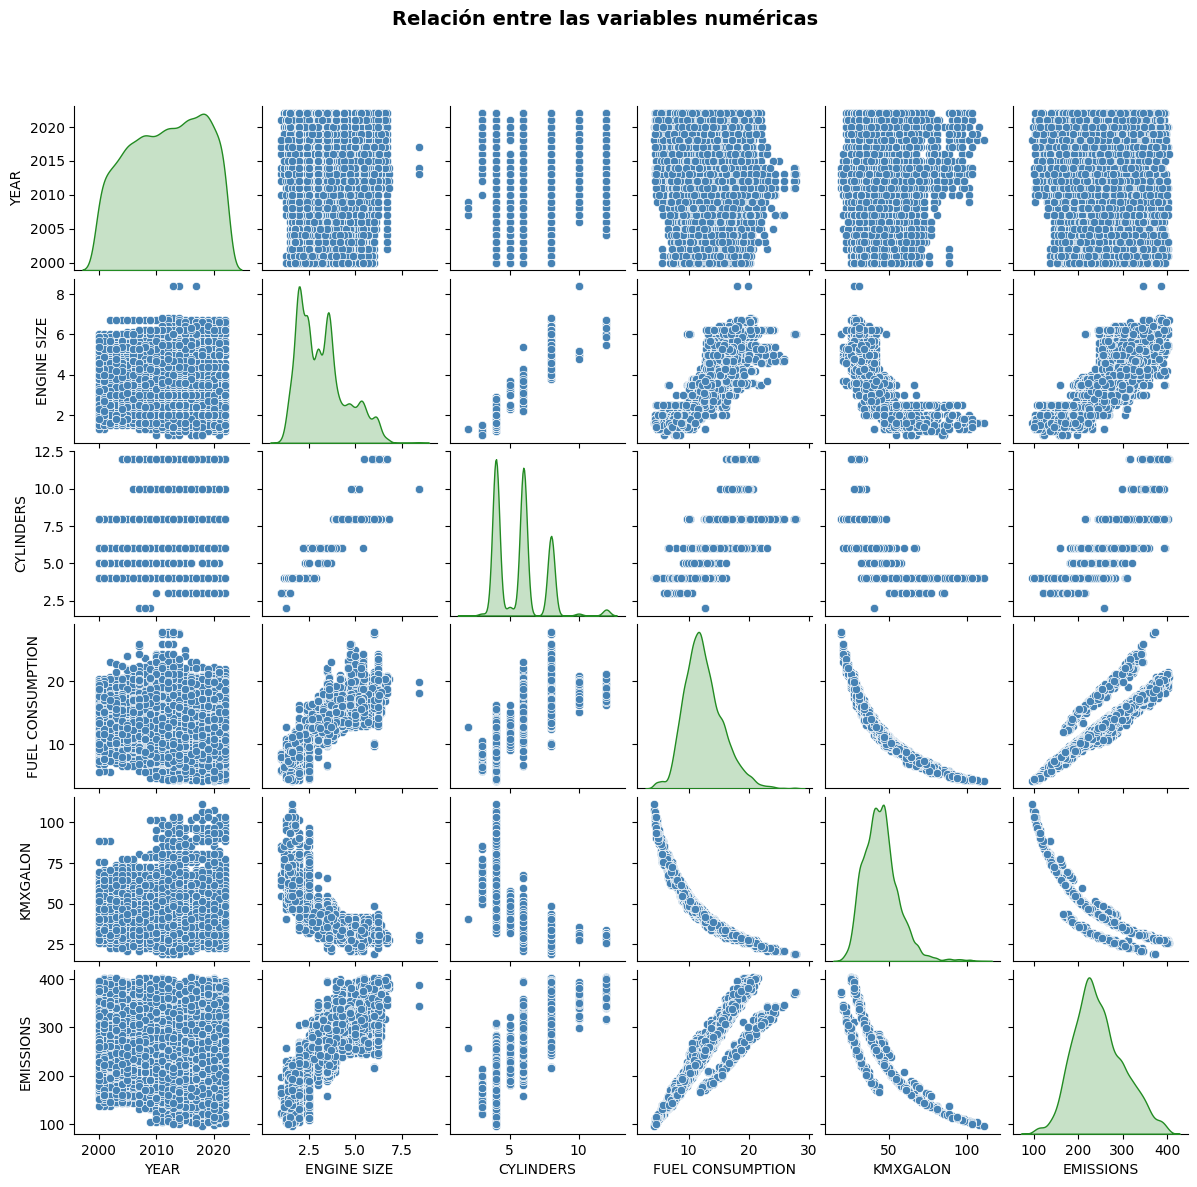

In [7]:
multiple_plot(1, d , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [ ]:
numCols.remove('EMISSIONS')

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('EMISSIONS Distribution')
sns.distplot(d.EMISSIONS, color='orange', bins=30)

plt.subplot(1,2,2)
plt.title('EMISSIONS Spread')
sns.boxplot(x=d.EMISSIONS, palette='nipy_spectral')

plt.show()

In [10]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

print(d.EMISSIONS.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,0.95,0.975,1]))

count   14093
mean      246
std        56
min        96
25%       207
50%       239
75%       281
85%       308
90%       324
95%       347
97.5%     365
100%      404
max       404
Name: EMISSIONS, dtype: float64


### Dumificación de las variables categóricas

In [ ]:
d =pd.get_dummies(d, drop_first=1)

In [12]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14093 entries, 0 to 14092
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   YEAR                           14093 non-null  int64  
 1   ENGINE SIZE                    14093 non-null  float64
 2   CYLINDERS                      14093 non-null  int64  
 3   FUEL CONSUMPTION               14093 non-null  float64
 4   KMXGALON                       14093 non-null  float64
 5   EMISSIONS                      14093 non-null  int64  
 6   RANGE_CATEGORY_LOW_RANGE       14093 non-null  bool   
 7   RANGE_CATEGORY_MID_RANGE       14093 non-null  bool   
 8   VEHICLE CLASS_SEDAN_COMPACT    14093 non-null  bool   
 9   VEHICLE CLASS_SUV_CROSSOVER    14093 non-null  bool   
 10  VEHICLE CLASS_TRUCK_VAN        14093 non-null  bool   
 11  VEHICLE CLASS_WAGON_SPECIALTY  14093 non-null  bool   
 12  FUEL_X                         14093 non-null 

### Declaración de las variables X e Y

In [ ]:
X = d.drop(columns = "EMISSIONS")
y = d['EMISSIONS']

### División de los datos en train y test


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [ ]:
num_vars = numCols

print(num_vars)

['YEAR', 'ENGINE SIZE', 'CYLINDERS', 'FUEL CONSUMPTION', 'KMXGALON']


### Escalar Variables númericas

In [ ]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

scaler = MinMaxScaler()

X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

X_train[num_vars].head(2)

YEAR  ENGINE SIZE  CYLINDERS  FUEL CONSUMPTION  KMXGALON
2582 0.5909       0.3649     0.4000            0.3629    0.2281
2320 0.6364       0.3514     0.4000            0.3544    0.2807

### Creación del modelo

In [ ]:
modelRF = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 'sqrt',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

modelRF.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=10, n_jobs=-1,
                      random_state=123)

In [ ]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelRF.predict(X = X_test)

rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones))
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_test, predicciones)
print(f"El error (r2) de test es: {r2}")

El error (rmse) de test es: 3.5937645561417484
El error (r2) de test es: 0.9956644288080401


In [ ]:
X_Completo = X
y_Completo = y

X_Completo[num_vars] = scaler.fit_transform(X_Completo[num_vars])

### Guardado del Scaler

In [ ]:
joblib.dump(scaler,'scaler/minmaxRandomForest.pkl')

['scaler/minmaxRandomForest.pkl']

### Validación empleando el Out-of-Bag error 


In [ ]:
train_scores = []
oob_scores   = []

estimator_range = range(1, 100, 5)


for n_estimators in estimator_range:

    modelRF = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error', #mean squared error
                max_depth    = None,
                max_features = 'sqrt',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelRF.fit(X_Completo, y_Completo)
    train_scores.append(modelRF.score(X_Completo, y_Completo))
    oob_scores.append(modelRF.oob_score_)



fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators(árboles): {estimator_range[np.argmax(oob_scores)]}")

Valor óptimo de n_estimators(árboles): 96


Hace validación cruzada para encontrar el mejor número de arboles.

Su objetivo es encontrar el número óptimo de arboles para minimizar el error de la validacion.

### Validación empleando k-cross-validation y neg_root_mean_squared_error


In [ ]:
train_scores = []
cv_scores    = []

estimator_range = range(1, 100, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:

    modelRF = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error', #mean squared error: mse
                max_depth    = None,
                max_features = 'sqrt',
                oob_score    = False,
                n_jobs       = -1, # se utilizan todos los núcleos disponibles del procesador
                random_state = 123
             )

    # Error de train
    modelRF.fit(X_Completo, y_Completo)
    predicciones = modelRF.predict(X = X_Completo)
    rmse = np.sqrt(mean_squared_error(
            y_true  = y_Completo,
            y_pred  = predicciones))
    train_scores.append(rmse)

    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelRF,
                X         = X_Completo,
                y         = y_Completo,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    cv_scores.append(-1*scores.mean())

fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

Valor óptimo de n_estimators: 71


Cada árbol dentro del bosque no usa todas las variables (X) para dividir los nodos.
En cada división, el modelo elige aleatoriamente un subconjunto de características (predictores) para decidir el mejor punto de corte.

Este código busca el número óptimo de variables (max_features) que cada árbol debe considerar para lograr el mejor equilibrio entre ajuste y generalización, midiendo con el error Out-of-Bag (OOB).

### Validación empleando el Out-of-Bag error

In [ ]:
train_scores = []
oob_scores   = []

max_features_range = range(1, X_Completo.shape[1] + 1, 1) 


for max_features in max_features_range:
    modelRF = RandomForestRegressor(
                n_estimators = 20,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelRF.fit(X_Completo, y_Completo)
    train_scores.append(modelRF.score(X_Completo, y_Completo))
    oob_scores.append(modelRF.oob_score_)

fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

Valor óptimo de max_features: 4


### Validación empleando k-cross-validation y neg_root_mean_squared_error

In [ ]:
train_scores = []
cv_scores    = []

max_features_range = range(1, X_Completo.shape[1] + 1, 1)

for max_features in max_features_range:

    modelRF = RandomForestRegressor(
                n_estimators = 20,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )

    # Error de train
    modelRF.fit(X_Completo, y_Completo)
    predicciones = modelRF.predict(X = X_Completo)
    rmse = np.sqrt(mean_squared_error(
            y_true  = y_Completo,
            y_pred  = predicciones))
    train_scores.append(rmse)

    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelRF,
                X         = X_Completo,
                y         = y_Completo,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())

fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

Valor óptimo de max_features: 5


### Grid de hiperparámetros evaluados

In [ ]:
param_grid = ParameterGrid(
                {'n_estimators': [15, 20, 25], # Cantidad de árboles en el bosque
                 'max_features': [4, 9, 11, 12], # Número de características a considerar en cada división
                 'max_depth'   : [3, 10, 20]     # Profundidad máxima del árbol
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:

    modelRF = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )

    modelRF.fit(X_Completo, y_Completo)

    resultados['params'].append(params)
    resultados['oob_r2'].append(modelRF.oob_score_)
    print(f"Modelo: {params} \u2713")

resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(5)

Modelo: {'max_depth': 3, 'max_features': 4, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 4, 'n_estimators': 20} ✓
Modelo: {'max_depth': 3, 'max_features': 4, 'n_estimators': 25} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 20} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 25} ✓
Modelo: {'max_depth': 3, 'max_features': 11, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 11, 'n_estimators': 20} ✓
Modelo: {'max_depth': 3, 'max_features': 11, 'n_estimators': 25} ✓
Modelo: {'max_depth': 3, 'max_features': 12, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 12, 'n_estimators': 20} ✓
Modelo: {'max_depth': 3, 'max_features': 12, 'n_estimators': 25} ✓
Modelo: {'max_depth': 10, 'max_features': 4, 'n_estimators': 15} ✓
Modelo: {'max_depth': 10, 'max_features': 4, 'n_estimators': 20} ✓
Modelo: {'max_depth': 10, 'max_features': 4, 'n_estimators': 25} ✓
M

oob_r2  max_depth  max_features  n_estimators
26  0.9965         20             4            25
29  0.9956         20             9            25
32  0.9953         20            11            25
35  0.9950         20            12            25
17  0.9945         10             9            25

### Mejores hiperparámetros por out-of-bag error

In [ ]:
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,:]['oob_r2'], "R2")

--------------------------------------------
Mejores hiperparámetros encontrados (oob-r2)
--------------------------------------------
0.9965017909722304 R2


### Entrenameinto del modelo con múltiples hiperparámetros buscando el mejor


In [ ]:
# Definir el modelo AdaBoostRegressor
modelRF = RandomForestRegressor(random_state = 123)

CV = 10

parameters =  {
                'n_estimators': [15, 20, 25],
                'max_features': [9, 10, 11, 12],
                'max_depth'   : [5, 10, 20]
                }

grid_RF = GridSearchCV(
                    estimator  = modelRF,
                    param_grid = parameters,
                    scoring    =  'r2',         #'neg_root_mean_squared_error',
                    n_jobs     = - 1,
                    cv         = CV,
                    refit      = True,
                    verbose    = 3,
                    return_train_score = True
                   )

grid_RF.fit(X = X_Completo, y = y_Completo)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'max_features': [9, 10, 11, 12],
                         'n_estimators': [15, 20, 25]},
             return_train_score=True, scoring='r2', verbose=3)

In [ ]:
resultados = pd.DataFrame(grid_RF.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

param_max_depth  param_max_features  param_n_estimators  mean_test_score  \
26               20                   9                  25           0.9961   
25               20                   9                  20           0.9959   
24               20                   9                  15           0.9958   
28               20                  10                  20           0.9955   

    std_test_score  mean_train_score  std_train_score  
26          0.0010            0.9993           0.0000  
25          0.0011            0.9993           0.0000  
24          0.0010            0.9992           0.0000  
28          0.0014            0.9992           0.0001

In [ ]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Obtener los resultados del grid search
results_grid_RF = pd.DataFrame(grid_RF.cv_results_)

# Seleccionar las columnas deseadas
columns_grid_RF = ['param_max_depth']  + \
                    ['param_max_features']  + \
                    ['param_n_estimators']  + \
                    ['mean_test_score', 'std_test_score']  + \
                    [f'split{i}_test_score' for i in range(CV)]

# Filtrar y mostrar los resultados
results_grid_RF_filtered = results_grid_RF[columns_grid_RF]

# Crear la columna scoreWithStd: f1 / std
results_grid_RF_filtered['scoreWithStd'] = results_grid_RF_filtered.apply(
    lambda row: row['mean_test_score'] / row['std_test_score'] if row['std_test_score'] != 0 else 0,
    axis=1
)

# Encuentra el índice del máximo valor en la columna scoreWithStd
indice_max_scoreWithStd = results_grid_RF_filtered['scoreWithStd'].idxmax()

# Mostrar los scores promedios por cada parámetro
results_grid_RF_filtered[['param_max_depth', 'param_max_features','param_n_estimators', 'mean_test_score', 'std_test_score', 'scoreWithStd']]

param_max_depth  param_max_features  param_n_estimators  mean_test_score  \
0                 5                   9                  15           0.9584   
1                 5                   9                  20           0.9586   
2                 5                   9                  25           0.9591   
3                 5                  10                  15           0.9598   
4                 5                  10                  20           0.9599   
5                 5                  10                  25           0.9596   
6                 5                  11                  15           0.9583   
7                 5                  11                  20           0.9585   
8                 5                  11                  25           0.9585   
9                 5                  12                  15           0.9578   
10                5                  12                  20           0.9581   
11                5                  12                  25           0.9578   
12               10                   9                  15           0.9945   
13               10                   9                  20           0.9946   
14               10                   9                  25           0.9947   
15               10                  10                  15           0.9942   
16               10                  10                  20           0.9942   
17               10                  10                  25           0.9942   
18               10                  11                  15           0.9942   
19               10                  11                  20           0.9943   
20               10                  11                  25           0.9943   
21               10                  12                  15           0.9940   
22               10                  12                  20           0.9940   
23               10                  12                  25           0.9940   
24               20                   9                  15           0.9958   
25               20                   9                  20           0.9959   
26               20                   9                  25           0.9961   
27               20                  10                  15           0.9954   
28               20                  10                  20           0.9955   
29               20                  10                  25           0.9954   
30               20                  11                  15           0.9949   
31               20                  11                  20           0.9951   
32               20                  11                  25           0.9951   
33               20                  12                  15           0.9949   
34               20                  12                  20           0.9951   
35               20                  12                  25           0.9951   

    std_test_score  scoreWithStd  
0           0.0055      172.7190  
1           0.0052      183.0941  
2           0.0051      187.4873  
3           0.0046      206.6907  
4           0.0047      203.9238  
5           0.0048      200.3924  
6           0.0056      171.7388  
7           0.0054      176.7177  
8           0.0054      178.9273  
9           0.0056      170.3935  
10          0.0054      177.1284  
11          0.0055      174.8495  
12          0.0014      711.9911  
13          0.0013      759.4898  
14          0.0013      766.9268  
15          0.0011      923.5368  
16          0.0012      828.2428  
17          0.0012      845.5814  
18          0.0013      788.6688  
19          0.0015      673.3768  
20          0.0015      653.9770  
21          0.0012      820.6781  
22          0.0015      682.9722  
23          0.0015      665.1681  
24          0.0010      975.8382  
25          0.0011      939.3573  
26          0.0010      967.7302  
27          0.0013      757.7095  
28          0.0014      699.

In [30]:
# Se identifican los mejores hiperparámetros
best_params = grid_RF.best_params_
print('Best Parameters : ',best_params)

Best Parameters :  {'max_depth': 20, 'max_features': 9, 'n_estimators': 25}


In [31]:
# Top 3 de los mejores scores
results_grid_RF_filtered.sort_values(by='scoreWithStd', ascending=False).head(3)[
    ['param_max_depth', 'param_max_features','param_n_estimators', 'mean_test_score', 'std_test_score', 'scoreWithStd']]

param_max_depth  param_max_features  param_n_estimators  mean_test_score  \
24               20                   9                  15           0.9958   
26               20                   9                  25           0.9961   
25               20                   9                  20           0.9959   

    std_test_score  scoreWithStd  
24          0.0010      975.8382  
26          0.0010      967.7302  
25          0.0011      939.3573

In [32]:
# Seleccionar el registro correspondiente al índice máximo
registro_max_scoreWithStd = results_grid_RF_filtered.loc[indice_max_scoreWithStd]

registro_max_scoreWithStd.transpose()

param_max_depth       20.0000
param_max_features     9.0000
param_n_estimators    15.0000
mean_test_score        0.9958
std_test_score         0.0010
split0_test_score      0.9969
split1_test_score      0.9968
split2_test_score      0.9969
split3_test_score      0.9938
split4_test_score      0.9955
split5_test_score      0.9946
split6_test_score      0.9948
split7_test_score      0.9960
split8_test_score      0.9963
split9_test_score      0.9965
scoreWithStd         975.8382
Name: 24, dtype: float64

In [33]:
results_grid_RF_filtered.loc[indice_max_scoreWithStd]['mean_test_score']

np.float64(0.9957969808813887)

# Creación del modelo con los mejores hiperparámetros

In [ ]:
modelRF = RandomForestRegressor( max_depth = int(results_grid_RF_filtered.loc[indice_max_scoreWithStd]["param_max_depth"])
                               , max_features = int(results_grid_RF_filtered.loc[indice_max_scoreWithStd]["param_max_features"])
                               , n_estimators = int(results_grid_RF_filtered.loc[indice_max_scoreWithStd]["param_n_estimators"])
                               , random_state = 1234)


#Se entrena el modelo con los datos completos
modelRF.fit(X_Completo, y_Completo)

RandomForestRegressor(max_depth=20, max_features=9, n_estimators=15,
                      random_state=1234)

In [35]:
importancia_predictores = pd.DataFrame(
                            {'predictor': d.drop(columns = "EMISSIONS").columns,
                             'importancia': modelRF.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


predictor  importancia
4                        KMXGALON       0.6519
3                FUEL CONSUMPTION       0.2826
1                     ENGINE SIZE       0.0239
11                         FUEL_X       0.0115
2                       CYLINDERS       0.0104
12                         FUEL_Z       0.0103
0                            YEAR       0.0068
6        RANGE_CATEGORY_MID_RANGE       0.0008
9         VEHICLE CLASS_TRUCK_VAN       0.0008
8     VEHICLE CLASS_SUV_CROSSOVER       0.0007
7     VEHICLE CLASS_SEDAN_COMPACT       0.0004
10  VEHICLE CLASS_WAGON_SPECIALTY       0.0000
5        RANGE_CATEGORY_LOW_RANGE       0.0000

In [ ]:
joblib.dump(modelRF,'modelos/RForest_CV.pkl')

['RForest_CV.pkl']